In [9]:
# --- 0. 安装必要的库 ---
# 在Kaggle环境中，您需要先安装sentence-transformers
# 确保您的Kaggle Notebook已在 "Settings" -> "Internet" 中开启网络
!pip install -q sentence-transformers transformers

# --- 1. 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
try:
    # 尝试导入刚刚安装的库
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("错误：无法导入 SentenceTransformer。")
    print("请确保Kaggle Notebook已开启网络，并已成功运行 !pip install sentence-transformers。")
    sys.exit()

# --- 2. 设置字体和文件路径 (Kaggle路径) ---
# 按照您的要求，设置Kaggle输入目录
input_dir = '/kaggle/input/fundings/'

font_path_chinese = os.path.join(input_dir, 'simkai.ttf')
font_path_english = os.path.join(input_dir, 'times.ttf')
data_file = os.path.join(input_dir, '2025-jiaoyubu-fenci.csv')

# 检查字体文件
if not os.path.exists(font_path_chinese):
    print(f"警告: 字体文件 '{font_path_chinese}' 未找到。中文可能无法正确显示。")
    ch_font = fm.FontProperties()
else:
    ch_font = fm.FontProperties(fname=font_path_chinese)
    fm.fontManager.addfont(font_path_chinese)

if not os.path.exists(font_path_english):
    print(f"警告: 字体文件 '{font_path_english}' 未找到。非中文字符可能无法使用指定字体。")
    en_font = fm.FontProperties()
else:
    en_font = fm.FontProperties(fname=font_path_english)
    fm.fontManager.addfont(font_path_english)

# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False 

# --- 3. 加载和过滤数据 ---
print(f"正在从 '{data_file}' 加载数据...")
try:
    df = pd.read_csv(data_file)
except FileNotFoundError:
    print(f"错误: 数据文件 '{data_file}' 未找到。")
    print("请确保您的数据文件和字体文件已上传到Kaggle的 '/kaggle/input/fundings/' 数据集中。")
    sys.exit()
except Exception as e:
    print(f"读取CSV文件时出错: {e}")
    sys.exit()

print("数据加载成功。")
target_discipline = '管理学'
management_df = df[df['学科门类'] == target_discipline].copy()

if management_df.empty:
    print(f"错误：未能在数据中找到学科门类 '{target_discipline}'。")
    sys.exit()

# 获取项目标题列表
titles = management_df['项目名称'].dropna().tolist()
if not titles:
    print(f"错误：'{target_discipline}' 门类下没有找到有效的项目名称。")
    sys.exit()

print(f"找到了 {len(titles)} 个 '{target_discipline}' 门类的项目标题。")

# --- 4. 加载模型并生成编码 ---
model_name = 'jinaai/jina-embeddings-v2-base-zh'
print(f"正在从Hugging Face加载 '{model_name}' 模型...")
try:
    # Jina模型需要 trust_remote_code=True
    model = SentenceTransformer(model_name, trust_remote_code=True)
    print("模型加载成功。")
except Exception as e:
    print(f"加载 SentenceTransformer 模型时出错: {e}")
    print("请确保Kaggle环境已开启网络访问。")
    sys.exit()

print(f"正在为 {len(titles)} 个标题生成编码... (这可能需要一些时间)")
# show_progress_bar=True 在Kaggle Notebook中会显示一个进度条
embeddings = model.encode(titles, show_progress_bar=True)
print(f"编码生成完毕。编码维度: {embeddings.shape}")

# --- 5. K-means 聚类与评估 ---
K_range = range(2, 16) # K∈[2,15]
silhouette_scores = []
ch_scores = []
db_scores_inv = []

print("开始 K-means 聚类和评估循环 (K=2 到 15)...")
for k in K_range:
    # 使用 n_init=10 抑制未来版本的警告
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    
    # a. Silhouette 系数 (越高越好)
    silhouette = silhouette_score(embeddings, labels)
    silhouette_scores.append(silhouette)
    
    # b. Calinski–Harabasz 指数 (越高越好)
    ch = calinski_harabasz_score(embeddings, labels)
    ch_scores.append(ch)
    
    # c. Davies–Bouldin 指数 (越低越好)
    db = davies_bouldin_score(embeddings, labels)
    # 我们存储 1 - DB (越高越好)
    db_scores_inv.append(1 - db)
    
    print(f"  K={k}: Silhouette={silhouette:.3f}, CH={ch:.0f}, 1-DB={1-db:.3f}")

print("聚类评估完成。")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


正在从 '/kaggle/input/fundings/2025-jiaoyubu-fenci.csv' 加载数据...
数据加载成功。
找到了 353 个 '管理学' 门类的项目标题。
正在从Hugging Face加载 'jinaai/jina-embeddings-v2-base-zh' 模型...
模型加载成功。
正在为 353 个标题生成编码... (这可能需要一些时间)


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

编码生成完毕。编码维度: (353, 768)
开始 K-means 聚类和评估循环 (K=2 到 15)...
  K=2: Silhouette=0.038, CH=16, 1-DB=-3.484
  K=3: Silhouette=0.028, CH=13, 1-DB=-3.436
  K=4: Silhouette=0.034, CH=11, 1-DB=-3.436
  K=5: Silhouette=0.031, CH=11, 1-DB=-2.930
  K=6: Silhouette=0.030, CH=10, 1-DB=-3.011
  K=7: Silhouette=0.032, CH=9, 1-DB=-2.710
  K=8: Silhouette=0.027, CH=8, 1-DB=-2.836
  K=9: Silhouette=0.033, CH=8, 1-DB=-2.555
  K=10: Silhouette=0.033, CH=7, 1-DB=-2.517
  K=11: Silhouette=0.030, CH=7, 1-DB=-2.499
  K=12: Silhouette=0.030, CH=7, 1-DB=-2.618
  K=13: Silhouette=0.029, CH=7, 1-DB=-2.523
  K=14: Silhouette=0.024, CH=6, 1-DB=-2.421
  K=15: Silhouette=0.027, CH=6, 1-DB=-2.340
聚类评估完成。


正在生成评估图表...
图表已成功保存为: management_clustering_metrics.png (位于 /kaggle/working/ 目录)
正在显示图表: 管理学 聚类评估


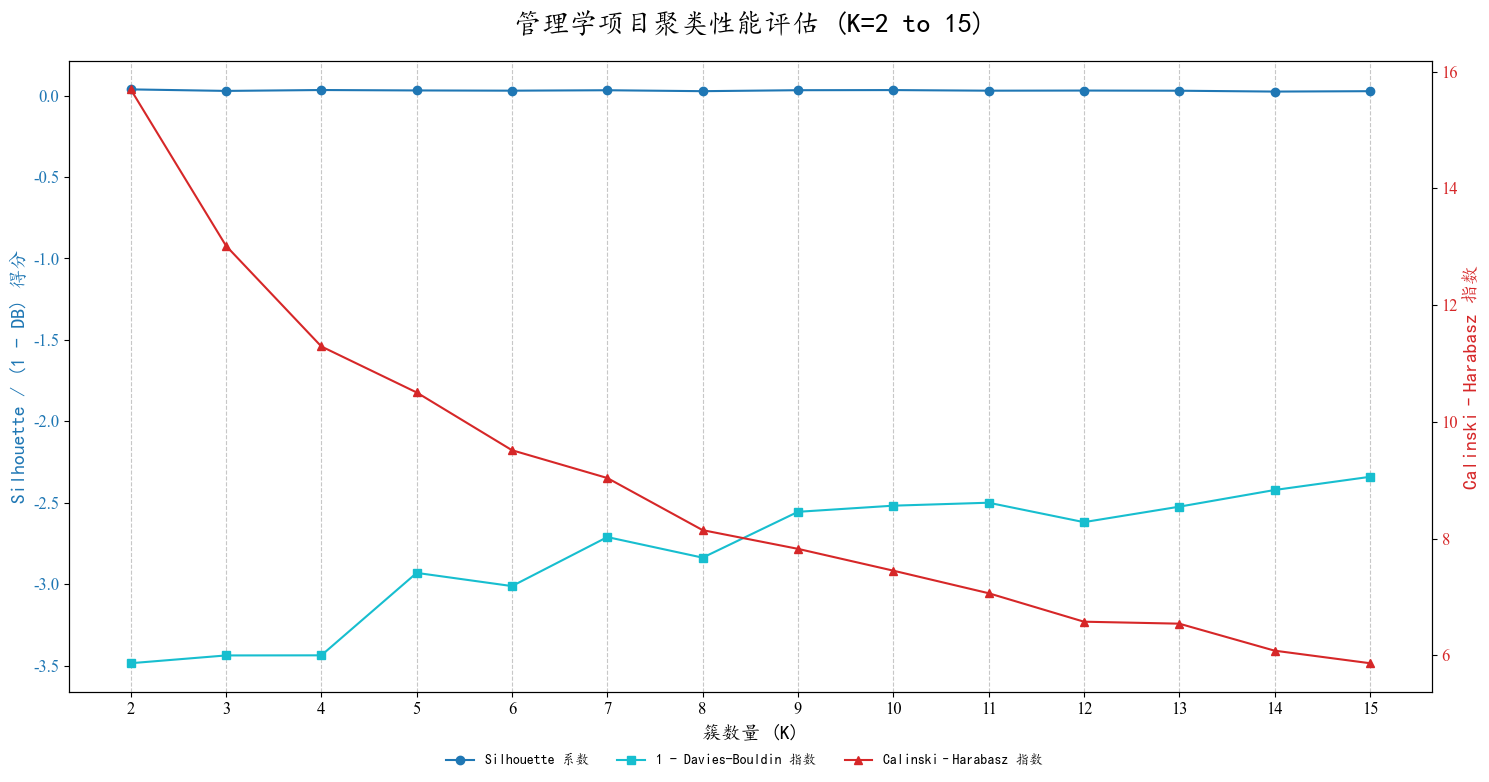

所有任务完成。


In [10]:
# --- 6. 绘制评估指标图表 ---
print("正在生成评估图表...")
fig, ax1 = plt.subplots(figsize=(15, 8))

# 标题
plt.title(f'{target_discipline}项目聚类性能评估 (K=2 to 15)', fontproperties=ch_font, fontsize=20, pad=20)

# X轴
ax1.set_xlabel('簇数量 (K)', fontproperties=ch_font, fontsize=14)
ax1.set_xticks(list(K_range))  # 确保X轴刻度为整数
plt.setp(ax1.get_xticklabels(), fontproperties=en_font, fontsize=12)

# Y轴1：Silhouette & 1-DB
color1 = 'tab:blue'
ax1.set_ylabel('Silhouette / (1 - DB) 得分', fontproperties=ch_font, fontsize=14, color=color1)

# 注意：这里的“减号”使用 ASCII '-'，避免使用 U+2212 ‘−’
line1 = ax1.plot(K_range, silhouette_scores, 'o-', color=color1, label='Silhouette 系数')
line2 = ax1.plot(K_range, db_scores_inv, 's-', color='tab:cyan', label='1 - Davies-Bouldin 指数')  # CHANGE: 用 '-' 而不是 ‘−’

ax1.tick_params(axis='y', labelcolor=color1)
plt.setp(ax1.get_yticklabels(), fontproperties=en_font, fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7, axis='x')

# Y轴2：CH 指数
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Calinski–Harabasz 指数', fontproperties=ch_font, fontsize=14, color=color2)
line3 = ax2.plot(K_range, ch_scores, '^-', color=color2, label='Calinski–Harabasz 指数')
ax2.tick_params(axis='y', labelcolor=color2)
plt.setp(ax2.get_yticklabels(), fontproperties=en_font, fontsize=12)

# --- 图例放在图下方 ---
# 聚合两条轴上的线
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]

# 先给底部留空间，再把图例放底部
fig.subplots_adjust(bottom=0.22)  # CHANGE: 为底部图例预留空间
legend = fig.legend(
    lines, labels,
    loc='lower center',            # CHANGE: 图例位置在底部居中
    ncol=3,                        # CHANGE: 单行展示三列
    frameon=False,
    prop=ch_font,
    bbox_to_anchor=(0.5, 0.02)     # CHANGE: 贴近底边，按需微调
)

fig.tight_layout(rect=[0, 0.05, 1, 1])  # CHANGE: 与底部图例协调（保留 5% 底边）


# --- 7. 显示和保存图表 ---
# 在Kaggle中，输出文件保存在 '/kaggle/working/' 目录
output_filename = 'management_clustering_metrics.png'

# ✅ 用显式 fig 引用（假设前面是 fig, ax = plt.subplots()）
try:
    # 先保存高清图像
    fig.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"图表已成功保存为: {output_filename} (位于 /kaggle/working/ 目录)")
except Exception as e:
    print(f"保存图表 '{output_filename}' 时出错: {e}")

# ✅ 再显示
try:
    print(f"正在显示图表: {target_discipline} 聚类评估")
    plt.show()
except Exception as e:
    print(f"显示图表时出错: {e}")

# ✅ 最后关闭，释放内存
plt.close(fig)
print("所有任务完成。")


In [11]:
target_discipline = '交叉学科/综合研究'
management_df = df[df['学科门类'] == target_discipline].copy()

if management_df.empty:
    print(f"错误：未能在数据中找到学科门类 '{target_discipline}'。")
    sys.exit()

# 获取项目标题列表
titles = management_df['项目名称'].dropna().tolist()
if not titles:
    print(f"错误：'{target_discipline}' 门类下没有找到有效的项目名称。")
    sys.exit()

print(f"找到了 {len(titles)} 个 '{target_discipline}' 门类的项目标题。")

# --- 4. 加载模型并生成编码 ---
model_name = 'jinaai/jina-embeddings-v2-base-zh'
print(f"正在从Hugging Face加载 '{model_name}' 模型...")
try:
    # Jina模型需要 trust_remote_code=True
    model = SentenceTransformer(model_name, trust_remote_code=True)
    print("模型加载成功。")
except Exception as e:
    print(f"加载 SentenceTransformer 模型时出错: {e}")
    print("请确保Kaggle环境已开启网络访问。")
    sys.exit()

print(f"正在为 {len(titles)} 个标题生成编码... (这可能需要一些时间)")
# show_progress_bar=True 在Kaggle Notebook中会显示一个进度条
embeddings = model.encode(titles, show_progress_bar=True)
print(f"编码生成完毕。编码维度: {embeddings.shape}")

# --- 5. K-means 聚类与评估 ---
K_range = range(2, 16) # K∈[2,15]
silhouette_scores = []
ch_scores = []
db_scores_inv = []

print("开始 K-means 聚类和评估循环 (K=2 到 15)...")
for k in K_range:
    # 使用 n_init=10 抑制未来版本的警告
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    
    # a. Silhouette 系数 (越高越好)
    silhouette = silhouette_score(embeddings, labels)
    silhouette_scores.append(silhouette)
    
    # b. Calinski–Harabasz 指数 (越高越好)
    ch = calinski_harabasz_score(embeddings, labels)
    ch_scores.append(ch)
    
    # c. Davies–Bouldin 指数 (越低越好)
    db = davies_bouldin_score(embeddings, labels)
    # 我们存储 1 - DB (越高越好)
    db_scores_inv.append(1 - db)
    
    print(f"  K={k}: Silhouette={silhouette:.3f}, CH={ch:.0f}, 1-DB={1-db:.3f}")

print("聚类评估完成。")

找到了 690 个 '交叉学科/综合研究' 门类的项目标题。
正在从Hugging Face加载 'jinaai/jina-embeddings-v2-base-zh' 模型...
模型加载成功。
正在为 690 个标题生成编码... (这可能需要一些时间)


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

编码生成完毕。编码维度: (690, 768)
开始 K-means 聚类和评估循环 (K=2 到 15)...
  K=2: Silhouette=0.047, CH=32, 1-DB=-3.580
  K=3: Silhouette=0.042, CH=29, 1-DB=-3.235
  K=4: Silhouette=0.035, CH=25, 1-DB=-2.967
  K=5: Silhouette=0.033, CH=22, 1-DB=-3.262
  K=6: Silhouette=0.033, CH=19, 1-DB=-3.163
  K=7: Silhouette=0.033, CH=17, 1-DB=-3.196
  K=8: Silhouette=0.032, CH=16, 1-DB=-2.882
  K=9: Silhouette=0.031, CH=15, 1-DB=-3.275
  K=10: Silhouette=0.028, CH=14, 1-DB=-3.140
  K=11: Silhouette=0.033, CH=13, 1-DB=-2.861
  K=12: Silhouette=0.031, CH=13, 1-DB=-2.901
  K=13: Silhouette=0.028, CH=12, 1-DB=-2.801
  K=14: Silhouette=0.030, CH=11, 1-DB=-2.784
  K=15: Silhouette=0.031, CH=11, 1-DB=-2.781
聚类评估完成。


正在生成评估图表...
图表已成功保存为: cross_clustering_metrics.png (位于 /kaggle/working/ 目录)
正在显示图表: 交叉学科/综合研究 聚类评估


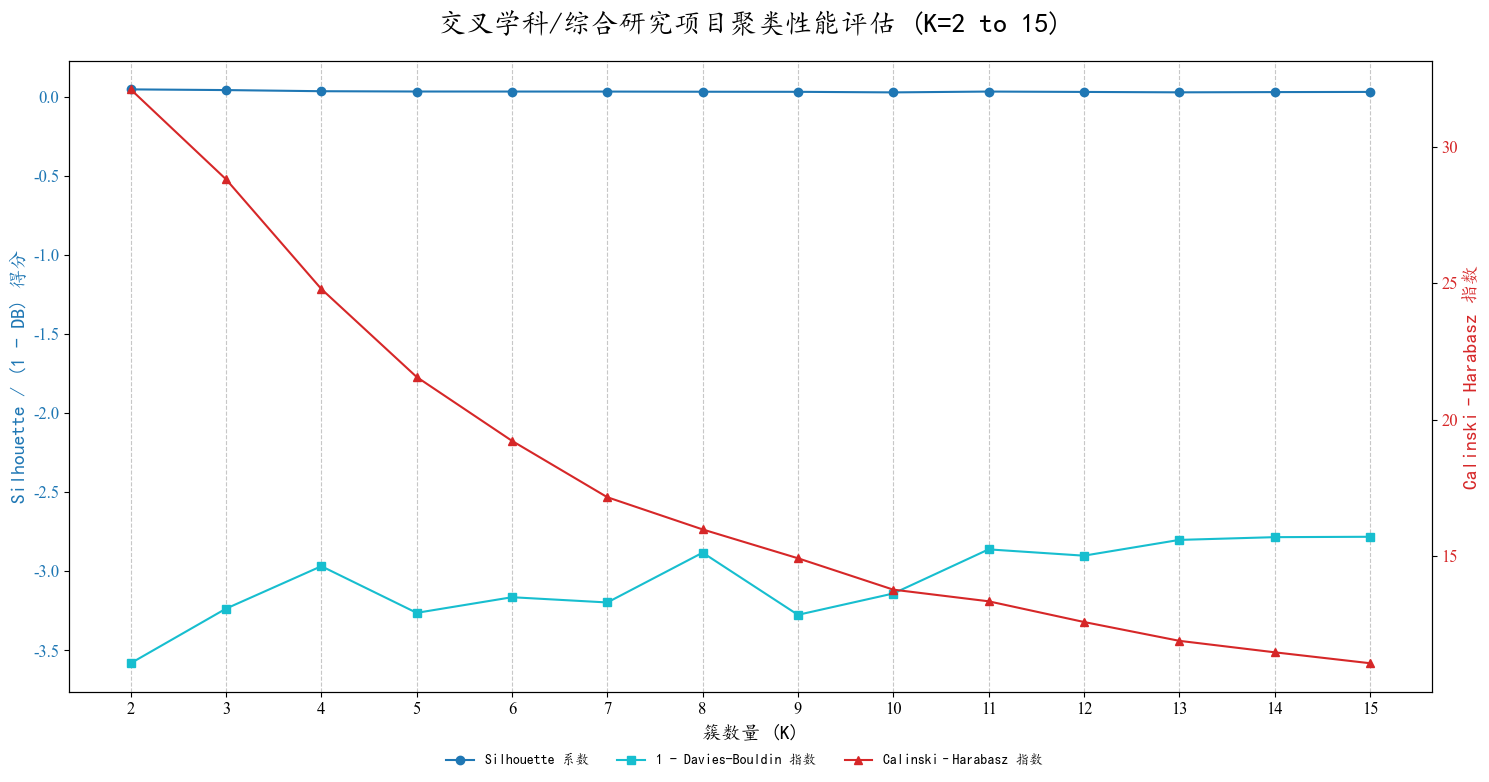

所有任务完成。


In [12]:
# --- 6. 绘制评估指标图表 ---
print("正在生成评估图表...")
fig, ax1 = plt.subplots(figsize=(15, 8))

# 标题
plt.title(f'{target_discipline}项目聚类性能评估 (K=2 to 15)', fontproperties=ch_font, fontsize=20, pad=20)

# X轴
ax1.set_xlabel('簇数量 (K)', fontproperties=ch_font, fontsize=14)
ax1.set_xticks(list(K_range))  # 确保X轴刻度为整数
plt.setp(ax1.get_xticklabels(), fontproperties=en_font, fontsize=12)

# Y轴1：Silhouette & 1-DB
color1 = 'tab:blue'
ax1.set_ylabel('Silhouette / (1 - DB) 得分', fontproperties=ch_font, fontsize=14, color=color1)

# 注意：这里的“减号”使用 ASCII '-'，避免使用 U+2212 ‘−’
line1 = ax1.plot(K_range, silhouette_scores, 'o-', color=color1, label='Silhouette 系数')
line2 = ax1.plot(K_range, db_scores_inv, 's-', color='tab:cyan', label='1 - Davies-Bouldin 指数')  # CHANGE: 用 '-' 而不是 ‘−’

ax1.tick_params(axis='y', labelcolor=color1)
plt.setp(ax1.get_yticklabels(), fontproperties=en_font, fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7, axis='x')

# Y轴2：CH 指数
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Calinski–Harabasz 指数', fontproperties=ch_font, fontsize=14, color=color2)
line3 = ax2.plot(K_range, ch_scores, '^-', color=color2, label='Calinski–Harabasz 指数')
ax2.tick_params(axis='y', labelcolor=color2)
plt.setp(ax2.get_yticklabels(), fontproperties=en_font, fontsize=12)

# --- 图例放在图下方 ---
# 聚合两条轴上的线
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]

# 先给底部留空间，再把图例放底部
fig.subplots_adjust(bottom=0.22)  # CHANGE: 为底部图例预留空间
legend = fig.legend(
    lines, labels,
    loc='lower center',            # CHANGE: 图例位置在底部居中
    ncol=3,                        # CHANGE: 单行展示三列
    frameon=False,
    prop=ch_font,
    bbox_to_anchor=(0.5, 0.02)     # CHANGE: 贴近底边，按需微调
)

fig.tight_layout(rect=[0, 0.05, 1, 1])  # CHANGE: 与底部图例协调（保留 5% 底边）


# --- 7. 显示和保存图表 ---
# 在Kaggle中，输出文件保存在 '/kaggle/working/' 目录
output_filename = 'cross_clustering_metrics.png'

# ✅ 用显式 fig 引用（假设前面是 fig, ax = plt.subplots()）
try:
    # 先保存高清图像
    fig.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"图表已成功保存为: {output_filename} (位于 /kaggle/working/ 目录)")
except Exception as e:
    print(f"保存图表 '{output_filename}' 时出错: {e}")

# ✅ 再显示
try:
    print(f"正在显示图表: {target_discipline} 聚类评估")
    plt.show()
except Exception as e:
    print(f"显示图表时出错: {e}")

# ✅ 最后关闭，释放内存
plt.close(fig)
print("所有任务完成。")
